# Building a Boardgame Recommender System

## Part 1: Scraping Boardgamegeek.com
*by Timothy Tan*

---

>[Boardgamegeek](https://boardgamegeek.com/) is board game nirvana for geeks, nerds and the occasional cool person. It is like Wikipedia to your science. This website holds a massive library of more than 90,000 games, with about 800,000 registered users and more than 150,000 active monthly users. 

>What is more impressive about this site is how open the data is. You can view anyone's boardgame collection, how they have rated their games, how often they have been playing and even their wishlist of games to buy and/or try. The notion that this website is like the swiss army knife of the boardgaming world makes it easy to entrust it with everything boardgame-related in one's life

### Yummy, yummy ratings...
>With the wealth of games and the dearth of time, a good boardgame recommender seems like the ideal solution to helping one choose wisely. The beauty of Boardgamegeek (or BGG for short) is its rating system. Users can rate games on a scale of 1 to 10. There is even a rubric to suggest how you might want to rate your games. It is entirely up to you however and some users even give ratings to 2 decimal places

![Bgg ratings](./assets/BGG_ratings.png)

>What's more, the ratings are colour coded on the webpage for quick identification. 

>Bloody-red belongs to a rating of 1 and it gets lighter till rating 5 where it turns purple. 
The transition from a sky-blue 7-rating and a light-green 8-rating is distinct, only to get to its darkest shade of green at 10

### Scraping and calling
>There exists a python module that allows one access to BGG's XML APIs via pythonic methods and classes. It unfortunately is not versatile enough for my needs. I will be scraping the page of the website where I sort all games in descending order of number of ratings. This means the game where most users have rated it will be right at the top. I will then scrape this page to gather the list of games up till the point where I hit the game with just less than 1000 ratings. This will be my game list.

>I will then be making API calls to gather the rating data for each game in the game list, as well as the users that have provided them. This will become my ratings list. I will then process this ratings list into an N x M matrix of N rows of users by M columns of games. The values in the matrix will be the ratings provided by users for games

### Regular imports

In [8]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from time import sleep


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set_style('white')


### Here I have a function that helps to ensure that our http requests get fulfilled despite disconnection.

In [31]:
def request(msg, slp=1):
    '''A wrapper to make robust https requests.'''
    status_code = 500  # Want to get a status-code of 200
    while status_code != 200:
        sleep(slp)  # Don't ping the server too often
        try:
            r = requests.get(msg)
            status_code = r.status_code
            if status_code != 200:
                print "Server Error! Response Code {}. Retrying...".format(r.status_code)
        except:
            print "An exception has occurred, probably a momentory loss of connection. Waiting one seconds..."
            sleep(1)
    return r

# Scraping for list of games

### Here's the page I'll be scraping and running a while loop to loop pages until I get less than 1000 ratings in the highlighted column
![Games sorted in descending order of number of ratings](./assets/sorted_games.png)

### Output of scraping that makes sense by reading together with code below
![scraping](./assets/scraping.png)

In [3]:
# Initialize a DF to hold all our scraped game info
games = pd.DataFrame(columns=["gameid", "gamename", "nratings","gamerank"])
min_nratings = 100000 # Set to a high number to satisfy while condition
npage = 1

# Scrape successful pages in the results until we get down to games with < 1000 ratings each
while min_nratings > 1000:
    # Get full HTML for a specific page in the full listing of boardgames sorted by 
    r = request("https://boardgamegeek.com/browse/boardgame/page/{}?sort=numvoters&sortdir=desc".format(npage))
    soup = BeautifulSoup(r.text, "html.parser")    
    
    # Get rows for the table listing all the games on this page. 100 per page
    table = soup.find_all("tr", attrs={"id": "row_"})
    # DF to hold this page's results
    temp_df = pd.DataFrame(columns=["gameid", "gamename", "nratings", "gamerank"], index=range(len(table)))  
    
    # Loop through each row and pull out the info for that game
    for idx, row in enumerate(table):
        links = row.find_all("a")
        try:
            gamerank = links[0]['name'] #Get rank of game
        except Exception: # Expansions will not have ranks and will be recorded as NaN rows in our dataframe
            continue
        gamelink = links[1]  # Get the relative URL for the specific game
        gameid = int(gamelink["href"].split("/")[2])  # Get the game ID by parsing the relative URL
        gamename = links[2].contents[0]  # Get the actual name of the game as the link contents

        ratings_str = row.find_all("td", attrs={"class": "collection_bggrating"})[2].contents[0]
        #split on white space to leave list of string of number, join on empty space then change to int datatype
        nratings = int("".join(ratings_str.split()))
        temp_df.iloc[idx, :] = [gameid, gamename, nratings, gamerank] #Add to temp_df
        
    # Concatenate the results of this page to the master dataframe
    min_nratings = temp_df["nratings"].min()  # The smallest number of ratings of any game on the page
    print "Page {} scraped, minimum number of ratings was {}".format(npage, min_nratings)
    games = pd.concat([games, temp_df], axis=0)
    npage += 1
    sleep(2) # Keep the BGG server happy.

Page 1 scraped, minimum number of ratings was 14862
Page 2 scraped, minimum number of ratings was 9760
Page 3 scraped, minimum number of ratings was 6912
Page 4 scraped, minimum number of ratings was 5461
Page 5 scraped, minimum number of ratings was 4435
Page 6 scraped, minimum number of ratings was 3750
Page 7 scraped, minimum number of ratings was 3209
Page 8 scraped, minimum number of ratings was 2808
Page 9 scraped, minimum number of ratings was 2464
Page 10 scraped, minimum number of ratings was 2216
Page 11 scraped, minimum number of ratings was 2035
Page 12 scraped, minimum number of ratings was 1814
Page 13 scraped, minimum number of ratings was 1664
Page 14 scraped, minimum number of ratings was 1535
Page 15 scraped, minimum number of ratings was 1427
Page 16 scraped, minimum number of ratings was 1334
Page 17 scraped, minimum number of ratings was 1238
Page 18 scraped, minimum number of ratings was 1168
Page 19 scraped, minimum number of ratings was 1086
Page 20 scraped, min

>We have scraped 21 pages (out of 941) in the games database. 

>Let's take a look at how many games we have added to our list.

In [4]:
print games.shape

games.head()

(2100, 4)


,gameid,gamename,nratings,gamerank
0,13,Catan,71279,251
1,822,Carcassonne,70895,130
2,30549,Pandemic,66881,64
3,36218,Dominion,58707,59
4,68448,7 Wonders,55341,37


In [5]:
games.tail()

,gameid,gamename,nratings,gamerank
95,23985,Midgard,975,1819
96,128931,Noblemen,975,1346
97,NaN,NaN,NaN,NaN
98,180956,One Night Ultimate Vampire,975,1430
99,NaN,NaN,NaN,NaN


>We see rows of NaNs in the bottom of our dataframe which corresponds to an expansion. It was created when we analyzed for a game rank in our try/except block in the code above, moving past the entry if it does not have a rank. Expansions do not have ranks on BGG but people are able to rate them.

>We will not be including expansions in our analysis as recommending an expansion to someone who already likes the game is quite a no-brainer and is not useful as a recommendation.

In [6]:
# Drop all NaNs which corresponds to expansions.
games.dropna(inplace=True)

In [7]:
games.shape

(1807, 4)

> We have dropped a grand total of 293 expansions, leaving us with 1807 games

> As the games dataframe was put together by concatenating several smaller dataframes together, the index will need to be reset.

In [8]:
# Reset the index since we concatenated a bunch of DFs with the same index into one DF
games.reset_index(inplace=True, drop=True)
# Write the DF to .csv for future use
games.to_csv("bgg_gamelist.csv", index=False, encoding="utf-8")
games.head()

,gameid,gamename,nratings,gamerank
0,13,Catan,71279,251
1,822,Carcassonne,70895,130
2,30549,Pandemic,66881,64
3,36218,Dominion,58707,59
4,68448,7 Wonders,55341,37


In [9]:
# To verify index is properly created
games.tail()

,gameid,gamename,nratings,gamerank
1802,195856,Bloodborne: The Card Game,976,1366
1803,2818,UNO Attack!,975,13989
1804,23985,Midgard,975,1819
1805,128931,Noblemen,975,1346
1806,180956,One Night Ultimate Vampire,975,1430


In [10]:
print "Number of games with > 1000 ratings is approximately {}".format(len(games))
print "Total number of ratings from all these games is {}".format(games["nratings"].sum())

Number of games with > 1000 ratings is approximately 1807
Total number of ratings from all these games is 8028799


> We have slightly more than 8 million ratings for analysis. Our next job is to collect them in order to form our ratings matrix.

# Making API calls to build our ratings list

>With our list of games and their associated ids, we can dive deeper into looking at the ratings for each game as well as who rated them. BGG provides an XML API where we can get the info we need.

>As it is, each call to the BGG API only returns a page of 100 ratings for each game. We will thus need to loop through each page for each game till we extract all the ratings from each game.

>Our approach is to make calls for each full page of 100 ratings first, followed by acquiring the last page of partial ratings separately.

In [11]:
# Create a column for number of full pages for each game
games["nfullpages"] = games["nratings"]//100

games.head()

,gameid,gamename,nratings,gamerank,nfullpages
0,13,Catan,71279,251,712.0
1,822,Carcassonne,70895,130,708.0
2,30549,Pandemic,66881,64,668.0
3,36218,Dominion,58707,59,587.0
4,68448,7 Wonders,55341,37,553.0


In [2]:
# Create the database and make a cursor to talk to it.
import sqlite3
connex = sqlite3.connect("bgg_ratings.db")  # Opens file if exists, else creates file
cur = connex.cursor()

In [53]:
#############################################################
# Gathering all ratings from all games in data set
#############################################################
# Get ratings page-by-page for all games, but do it in chunks of 150 games
for nm, grp in games.groupby(np.arange(len(games))//150):
    # Initialize a DF to hold all the responses for this chunk of games
    df_ratings = pd.DataFrame(columns=["gameid", "username", "rating"], index=range(grp["nratings"].sum()+100000))

    # Initialize indices for writing to the ratings dataframe
    dfidx_start = 0
    dfidx = 0
    
    # For this group of games, make calls until all FULL pages of every game have been pulled
    pagenum = 1
    while len(grp[grp["nfullpages"] > 0]) > 0: 
        # Get a restricted DF with only still-active games (have ratings pages left)
        active_games = grp[grp["nfullpages"] > 0]

        # Set the next chunk of the DF "gameid" column using the list of game IDs
        id_list = []
        for game in active_games["gameid"]:
            id_list += [game]*100
        dfidx_end = dfidx_start + len(active_games)*100
        df_ratings.iloc[dfidx_start:dfidx_end, df_ratings.columns.get_loc("gameid")] = id_list

        # Make the request with the list of all game IDs that have ratings left
        id_strs = [str(gid) for gid in active_games["gameid"]]
        gameids = ",".join(id_strs)
        sleep(1.5)  # Keep the server happy
        r = request("http://www.boardgamegeek.com/xmlapi2/thing?id=%s&ratingcomments=1&page=%i" % (gameids, pagenum))
#         while r.status_code != 200:
#             sleep(2)  # Keep the server happy
#             print("Server Error! Response Code %i. Retrying..." % (r.status_code))
#             r = requests.get("http://www.boardgamegeek.com/xmlapi2/thing?id=%s&ratingcomments;=1&page;=%i" % (gameids, pagenum))        
        soup = BeautifulSoup(r.text, "xml")
        comments = soup("comment")
#         print("Response status was %i - number of ratings retrieved was %i" % (r.status_code, len(comments)))

        # Parse the response and assign it into the dataframe
        l1 = [0]*len(active_games)*100
        l2 = [0]*len(active_games)*100
        j = 0
        for comm in comments:
            l1[j] = comm["username"]
            l2[j] = float(comm["rating"])
            j += 1
        df_ratings.iloc[dfidx_start:dfidx_end, df_ratings.columns.get_loc("username")] = l1
        df_ratings.iloc[dfidx_start:dfidx_end, df_ratings.columns.get_loc("rating")] = l2

        
        grp["nfullpages"] -= 1  # Decrement the number of FULL pages of each game id
        dfidx_start = dfidx_end     
        pagenum += 1  
        print("pagenum updated to %i" %(pagenum,))
    
    # Strip off the empty rows
    df_ratings = df_ratings.dropna(how="all")
    # Write this batch of all FULL pages of ratings for this chunk of games to the DB
    df_ratings.to_sql(name="ratings", con=connex, if_exists="append", index=False)    
    print("Processed ratings for batch #%i of games." % (nm))

Server Error! Response Code 504. Retrying...


/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


pagenum updated to 2
Server Error! Response Code 504. Retrying...
pagenum updated to 3
pagenum updated to 4
pagenum updated to 5
pagenum updated to 6
pagenum updated to 7
pagenum updated to 8
pagenum updated to 9
pagenum updated to 10
pagenum updated to 11
pagenum updated to 12
pagenum updated to 13
pagenum updated to 14
pagenum updated to 15
pagenum updated to 16
pagenum updated to 17
pagenum updated to 18
pagenum updated to 19
pagenum updated to 20
pagenum updated to 21
pagenum updated to 22
pagenum updated to 23
pagenum updated to 24
Server Error! Response Code 504. Retrying...
pagenum updated to 25
pagenum updated to 26
pagenum updated to 27
pagenum updated to 28
pagenum updated to 29
pagenum updated to 30
pagenum updated to 31
pagenum updated to 32
pagenum updated to 33
pagenum updated to 34
pagenum updated to 35
Server Error! Response Code 504. Retrying...
pagenum updated to 36
Server Error! Response Code 504. Retrying...
pagenum updated to 37
pagenum updated to 38
Server Error! 

> Phew! that took a while. If you can still recall, we still have one more page of ratings for each that game for which we have not made our API calls to. Let us check how our ratings dataframe looks like first.

In [55]:
df_ratings.shape

(98700, 3)

In [56]:
df_ratings.head()

,gameid,username,rating
0,98242,latharian1983,10
1,98242,ForlornWolf,10
2,98242,Phreekshow1,10
3,98242,krazytako78,10
4,98242,rrgeorge,10


> Looks good! Now let's finish up collecting our last page of ratings for each game

In [58]:
#############################################################
# Request the final partial page of ratings for each game
#############################################################
# Restore the correct number of FULL pages
games["nfullpages"] = games["nratings"]//100 

# Initialize a DF to hold all the responses over all the chunks of games
temp_ratings = pd.DataFrame(columns=["gameid", "username", "rating"], index=range(len(games)*100))

# Initialize indices for writing to the ratings dataframe
dfidx_start = 0
dfidx = 0

# Loop through game-by-game and request the final page of ratings for each game
for idx, row in games.iterrows():
    # Get the game ID and the last page number to request
    pagenum = row["nfullpages"] + 1
    gameid = row["gameid"]
    
    # Make the request for just the last page of ratings of this game
    sleep(1)  # Keep the server happy
    r = requests.get("http://www.boardgamegeek.com/xmlapi2/thing?id={}&ratingcomments=1&page={}".format(gameid, pagenum))
    while r.status_code != 200:
        sleep(2)  # Keep the server happy
        print("Server Error! Response Code %i. Retrying..." % (r.status_code))
        r = requests.get("http://www.boardgamegeek.com/xmlapi2/thing?id=[]&ratingcomments=1&page={}".format(gameid, pagenum))
    soup = BeautifulSoup(r.text, "xml")
    comments = soup("comment")

    # Set the next chunk of the DF "gameids" column with this gameid
    id_list = [gameid]*len(comments)
    dfidx_end = dfidx_start + len(comments)
    temp_ratings.iloc[dfidx_start:dfidx_end, temp_ratings.columns.get_loc("gameid")] = id_list

    # Parse the response and assign it into the dataframe
    l1 = [0]*len(comments)
    l2 = [0]*len(comments)
    j = 0
    for comm in comments:
        l1[j] = comm["username"]
        l2[j] = float(comm["rating"])
        j += 1
    temp_ratings.iloc[dfidx_start:dfidx_end, temp_ratings.columns.get_loc("username")] = l1
    temp_ratings.iloc[dfidx_start:dfidx_end, temp_ratings.columns.get_loc("rating")] = l2

    dfidx_start = dfidx_end   # Increment the starting index for next round        

    if idx%100 == 0:
        print("Finished with a chunk of 100 games.")
        
# Strip off the empty rows
temp_ratings = temp_ratings.dropna(how="all")

# Write this final batch of all partial pages of ratings for this chunk of games to the DB
temp_ratings.to_sql(name="ratings", con=connex, if_exists="append", index=False)

Finished with a chunk of 100 games.
Finished with a chunk of 100 games.
Finished with a chunk of 100 games.
Finished with a chunk of 100 games.
Finished with a chunk of 100 games.
Finished with a chunk of 100 games.
Finished with a chunk of 100 games.
Finished with a chunk of 100 games.
Finished with a chunk of 100 games.
Finished with a chunk of 100 games.
Finished with a chunk of 100 games.
Finished with a chunk of 100 games.
Finished with a chunk of 100 games.
Finished with a chunk of 100 games.
Finished with a chunk of 100 games.
Finished with a chunk of 100 games.
Finished with a chunk of 100 games.
Finished with a chunk of 100 games.
Finished with a chunk of 100 games.


In [59]:
# Save our changes and close the connection
connex.commit()
connex.close()

# Analyze ratings dataframe
>With our ratings data stored in a database, we can start analyzing this table and perform some EDA

In [60]:
# Opens file if exists, else creates file
connex = sqlite3.connect("bgg_ratings.db")  

In [61]:
# This object lets us actually send messages to our DB and receive results
cur = connex.cursor()  

In [63]:
# Get everything to see what we have first
sql = "SELECT * FROM ratings"
ratings = pd.read_sql(sql, con=connex)

In [64]:
# Randomly sample 10 rows from the dataframe
ratings.sample(n=10)

,gameid,username,rating
363957,9209,Mighty Jim,7.00
7853219,130960,NickRice,10.00
6026042,30957,cylonathalf,5.00
3243183,28720,gamesghost,9.00
760360,178900,tormariu,9.00
1919554,157354,Gamer John,8.00
1757722,39463,K0miss4r,8.00
6616345,175199,RoadHouse,7.00
3023729,27588,hymie,7.75
4651635,2425,hayden76,8.00


In [65]:
ratings.shape

(8064334, 3)

> Looks like a lot more rows than what was calculated from the sum of the nratings column (8,028,799)

In [66]:
#Look at all duplicated entries
ratings[ratings.duplicated(keep=False)]

,gameid,username,rating
258,13,Thirost,10.0
259,13,Thirost,10.0
394,13,imgame,10.0
477,13,toma18198,10.0
478,13,toma18198,10.0
602,13,Geeken,10.0
894,13,CatinaBox,10.0
950,13,Tigger40k,10.0
978,13,CatinaBox,10.0
1014,13,silensence,10.0


> There seems to be repeated rows in our dataset. This is because users are able to rate different versions of the game. Versions could be differentiated by language or by edition through subsequent printings by either the same or different publishers. If a user chooses to add more versions of a game to their collection, they have the option of attributing the same rating to each copy. Choosing to rate the game separately will result in duplicated rows if they choose to rate the games at the same score.

In [67]:
# Drop all duplicates
ratings = ratings.drop_duplicates()

In [68]:
ratings.shape

(8029041, 3)

> The number of ratings is still slightly more than what I expect in the nratings column in games(8,028,799). A difference of about 242.

In [69]:
# Inspect the duplicates on both username and gameid
ratings[ratings.duplicated(subset=['username', 'gameid'], keep=False)]

,gameid,username,rating
1215,13,Optoman,10.00
1444,13,RonCarlson01,10.00
1505,13,Kemari,10.00
1676,13,iicorps1,10.00
2054,13,kryrayne,10.00
2082,13,General_Warhammer,10.00
2431,13,ingedico,10.00
2641,13,ForgottenHalcyonDays,10.00
2811,13,finallyiamnoone,10.00
2912,13,slycreations,10.00


> We can see the reason for the duplicates is due to the same user rating the same game twice or more. This can happen when a user adds a new version / edition of the game to his collection and gives it a different rating. Or like the example below, just can't make up his mind

In [70]:
ratings.loc[(ratings['gameid']==197070) & (ratings['username']== 'paedophobic')]

,gameid,username,rating
7704863,197070,paedophobic,9.88
7704864,197070,paedophobic,9.81
7704866,197070,paedophobic,9.55
7749807,197070,paedophobic,8.96
7749846,197070,paedophobic,8.26
7809823,197070,paedophobic,7.16
7839800,197070,paedophobic,6.41
7839892,197070,paedophobic,5.71
8052709,197070,paedophobic,4.84
8052729,197070,paedophobic,3.37


> Unfortunately, we have no timestamp data of when the ratings were given. The next best alternative is to compute the mean of the set of ratings since the ratings are continuous variables on a scale of 1-10

In [71]:
# rows where (game, user) is duplicate
multis = ratings.loc[ratings.duplicated(subset=["gameid", "username"], keep=False)] 
# rows where (game, user) is NOT duplicate
no_multis = ratings.loc[~ratings.duplicated(subset=["gameid", "username"], keep=False)] 

In [72]:
# replace each set of duplicates with avg
means = multis.groupby(["gameid", "username"])["rating"].mean().reset_index() 
means.head()

,gameid,username,rating
0,1,Celtic,8.75
1,1,Iago71,8.25
2,1,Morganza,8.05
3,1,Oramon,9.50
4,1,PaulinTheLion,7.50


In [73]:
# Add the de-duplicated average rows back in
ratings = pd.concat([no_multis, means])  

In [74]:
ratings.duplicated(subset=['gameid', 'username']).sum()

0

> Great! we've removed all duplicate entries in our ratings dataframe. Let's save it as a separate database

In [77]:
connex = sqlite3.connect("bgg_ratings_deduplicated.db") 
ratings.to_sql("ratings", connex, index=False)
connex.commit()
connex.close()

In [78]:
len(ratings) - games['nratings'].sum()

-14418

> The difference observed here can be attributed to the flux of game ratings entering the system from the time we scraped the game page to actually getting the rating data through api calls.

In [79]:
len(ratings['gameid'].unique())

1807

In [80]:
len(ratings['username'].unique())

204483

> Our final matrix should be of size 204,483 x 1807. Let's do a check to see whether our scraped data is comparable to what is on the server. While we're at it, let's look at some plots of 3 random samples as well.

[u'Age of War'] Our Data: Mean = 6.43. StdDev = 1.26
[u'Age of War'] Server Stats: Mean = 6.43. StdDev = 1.26
[u'Streetcar'] Our Data: Mean = 6.46. StdDev = 1.25
[u'Streetcar'] Server Stats: Mean = 6.46. StdDev = 1.25
[u'Tikal'] Our Data: Mean = 7.34. StdDev = 1.20
[u'Tikal'] Server Stats: Mean = 7.34. StdDev = 1.20


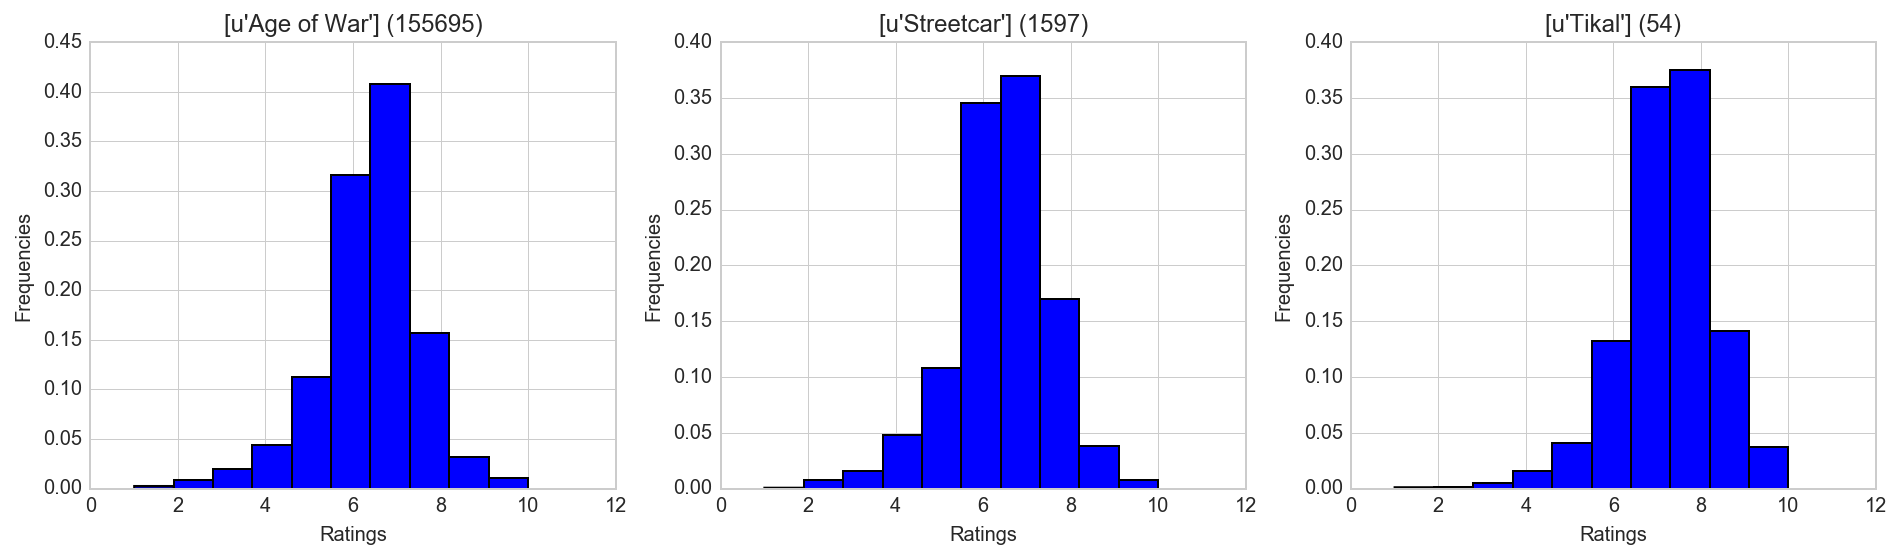

In [83]:
# Plot histogram of games
fig, ax = plt.subplots(figsize=[16, 4], nrows=1, ncols=3)
ax = ax.ravel()
for idx, game in enumerate(games["gameid"].sample(n=3, random_state=999)):
    df = ratings[ratings["gameid"] == game]
    nm = games.loc[games["gameid"] == game, "gamename"].values
    __ = ax[idx].hist(df["rating"], bins=10, normed=True)
    ax[idx].set_title("{} ({})".format(nm, game))
    ax[idx].set_xlabel('Ratings')
    ax[idx].set_ylabel('Frequencies')
    print "{} Our Data: Mean = {:.2f}. StdDev = {:.2f}".format(nm, df["rating"].mean(), df["rating"].std())
    
    # Request actual stats from the server to compare with scraped data
    r = requests.get("http://www.boardgamegeek.com/xmlapi2/thing?id={}&stats=1".format(game))
    soup = BeautifulSoup(r.text, "xml")
    std = float(soup("stddev")[0]["value"])
    mn = float(soup("average")[0]["value"])
    print "{} Server Stats: Mean = {:.2f}. StdDev = {:.2f}".format(nm, mn,std)
    sleep(1.5)

> We can see that most games have a normal distribution with a peak at around 7

# Transform to user-item ratings matrix
>We will want to pivot our ratings matrix into a table of size N x M where N is the total number of users as rows and M is the total number of games as columns. The values in the matrix will be populated by the ratings given by each user to games.

>We will select users with at least 10 or more ratings in our database to in order to make our predictions and recommendations

In [6]:
# Select users with at least 10 or more ratings into a new dataframe
connex=sqlite3.connect("bgg_ratings_deduplicated.db")
sql="""
SELECT username, COUNT(username) as games_rated
FROM ratings
GROUP BY username
HAVING games_rated >= 10
"""
users = pd.read_sql(sql, connex)

In [89]:
users.head()

,username,games_rated
0,mycroft,13
1,-=Yod@=-,183
2,-Johnny-,341
3,-Loren-,67
4,-LucaS-,19


> In the user dataframe, we can see each user and how many games from our database of 1807 they have rated.

In [112]:
users.describe()

,games_rated
count,120679.000000
mean,63.976110
std,84.004832
min,10.000000
25%,18.000000
50%,35.000000
75%,72.000000
max,1720.000000


>The median number of games rated is 35 while the mean is around 64. There seems to be a few individuals that rate so many games that it skews the distribution. The max number of games rated by one or more individuals is 1720 out of a possible 1807 games!

In [114]:
users.sort_values('games_rated', ascending=False).head(10)

,username,games_rated
89790,leffe dubbel,1720
117618,we3die,1510
35286,Nap16,1442
13219,Doel,1381
21450,Hessu68,1363
51507,TomVasel,1324
60536,averagerating,1286
19060,Gibmaatsuki,1249
54112,Walt Mulder,1170
37814,PBrennan,1158


>Looks like there is only one individual with the honour of rating the most games in our dataset.

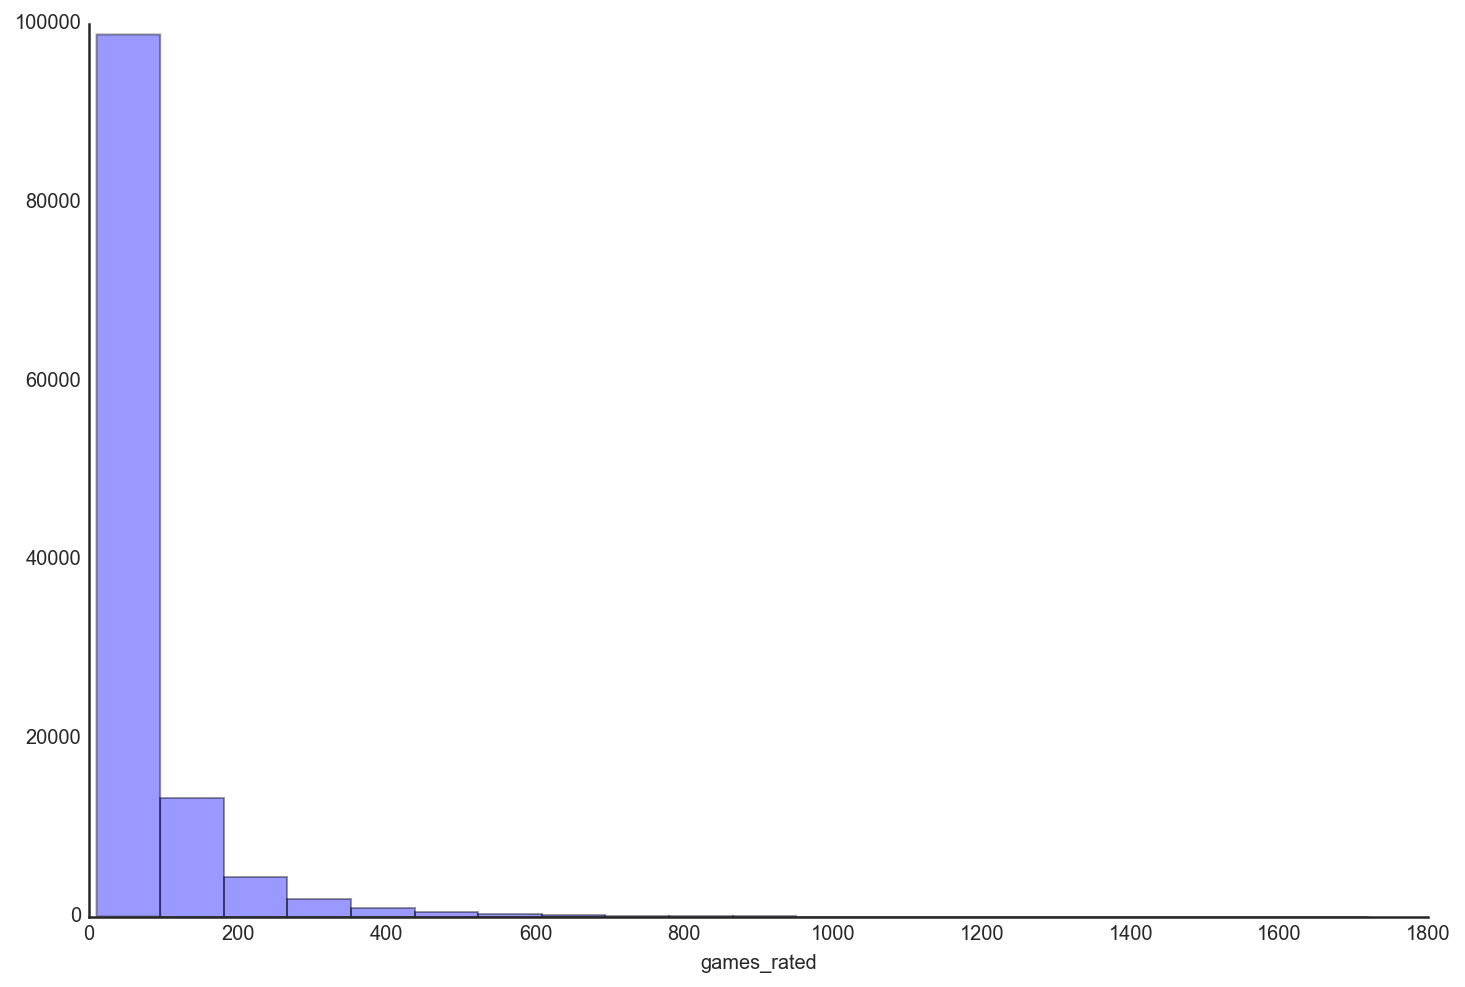

In [16]:
plt.figure(figsize=(12,8))
sns.distplot(users['games_rated'], bins=20, kde=False)
sns.despine()
plt.show()

>We can see that the majority of users rate 100 games or less, making the distribution significantly positively skewed. Let's perform a log transformation to see if we are able to approximate a normal distribution

In [13]:
users['log_games_rated'] = np.log(users['games_rated'])

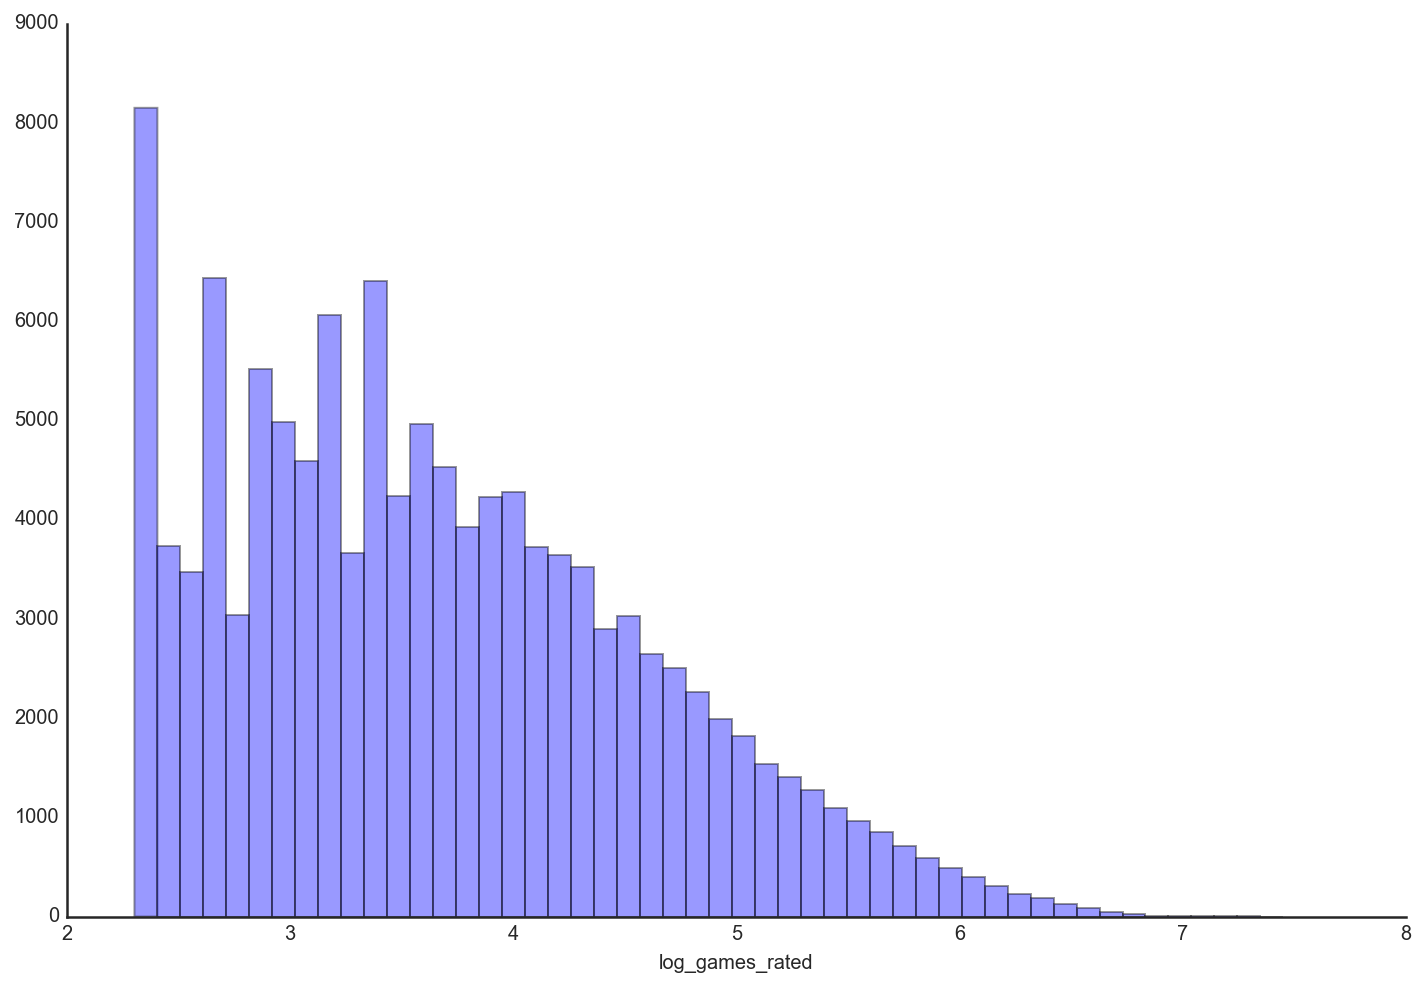

In [15]:
plt.figure(figsize=(12,8))
sns.distplot(users['log_games_rated'], kde=False)
sns.despine()
plt.show()

>Even with a log transformation, the distribution of games rated by users is skewed right.

In [18]:
games = pd.read_csv('bgg_gamelist.csv')

In [20]:
games['nratings'].describe()

count     1807.000000
mean      4443.164914
std       6419.446775
min        975.000000
25%       1397.500000
50%       2217.000000
75%       4555.500000
max      71279.000000
Name: nratings, dtype: float64

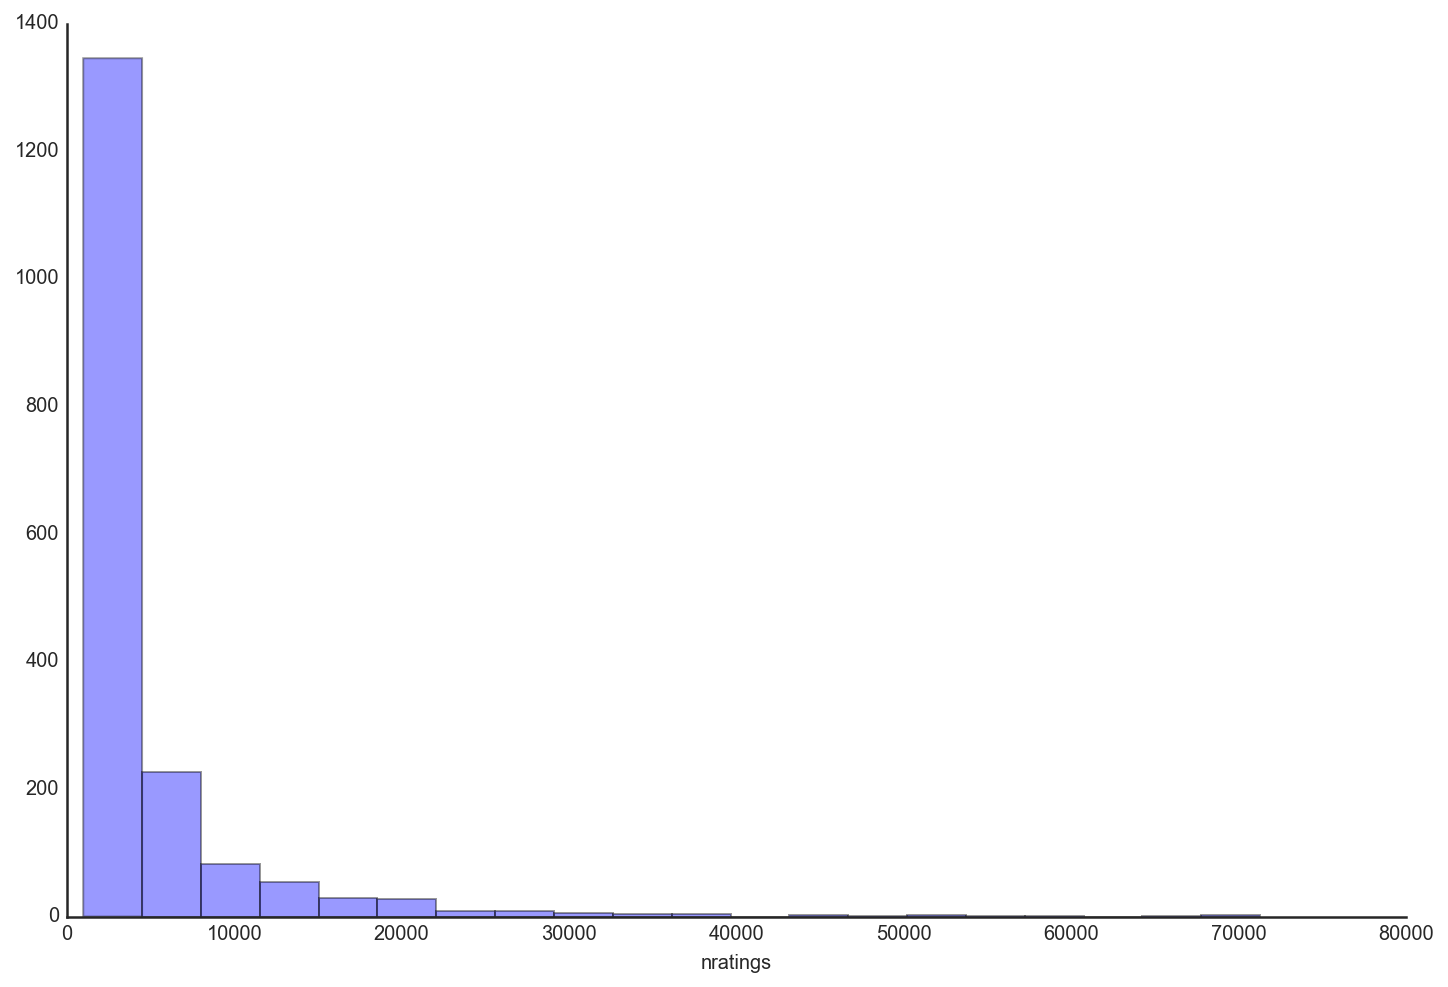

In [19]:
plt.figure(figsize=(12,8))
sns.distplot(games['nratings'], bins=20, kde=False)
sns.despine()
plt.show()

>The distribution of game ratings looks eerily similar to that of the rating distribution of users. This is not surprising given some games are more popular than others and yet the vast majority of games have few ratings compared to a minority of popular ones that gets exponentially more ratings just because they are more well-known.

In [90]:
#Total number of users included in analysis
len(users)

120679

In [91]:
#Verify no duplicated users
users.duplicated().sum()

0

> Let's take a look at how sparse our data actually is

In [101]:
max_n_ratings = len(ratings["gameid"].unique())*len(ratings["username"].unique())
actual_n_ratings = len(ratings)
print 'Number of possible values in ratings matrix:', max_n_ratings
print 'Number of actual ratings:', actual_n_ratings
print "Sparsity of Ratings Data is {:.2f}".format(100*float(actual_n_ratings)/max_n_ratings)

Number of possible values in ratings matrix: 369500781
Number of actual ratings: 8014381
Sparsity of Ratings Data is 2.00


> Nice and sparse. Just like any good ratings matrix..=)

>Let's now create a subset of our ratings matrix with users that have rated at least 10 or more

In [95]:
rate10 = ratings[ratings['username'].isin(users['username'])]

In [96]:
rate10['username'].nunique()

120679

>Let's take a look at how sparse our data is now that we have selected users with more ratings.

In [2]:
rate10 = pd.read_pickle('rate10_pickle')

In [3]:
max_n_ratings = len(rate10["gameid"].unique())*len(rate10["username"].unique())
actual_n_ratings = len(rate10)
print 'Number of possible values in ratings matrix:', max_n_ratings
print 'Number of actual ratings:', actual_n_ratings
print "Sparsity of Ratings Data is {:.2f}".format(100*float(actual_n_ratings)/max_n_ratings)

Number of possible values in ratings matrix: 218066953
Number of actual ratings: 7720573
Sparsity of Ratings Data is 3.54


>Seems better, but only slightly. All those NaNs are going to be a 'lovely' sight.

>We finally transform our long ratings table into our required squarish matrix table by performing a pivot table function

In [102]:
ratings_pivot = pd.pivot_table(rate10, values='rating', index='username', columns='gameid')

In [103]:
ratings_pivot.head()

gameid,1,3,5,7,9,10,11,12,13,14,...,206718,206941,207336,207691,207830,209010,209685,209778,213893,219513
username,,,,,,,,,,,,,,,,,,,,,
mycroft,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-=Yod@=-,NaN,NaN,NaN,7.5,NaN,NaN,7.0,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Johnny-,5.0,4.0,7.0,NaN,NaN,4.0,6.0,5.0,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Loren-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-LucaS-,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
ratings_pivot.shape

(120679, 1807)

>With the ratings matrix, we can see many NaNs in place where a user has not yet provided a rating for a particular game. Our job is to predict values for these empty slots in the matrix and provide recommendations to the user. Before we pickle and proceed on to modeling, lets take a look at the rating distribution of our users.

In [33]:
user_ratings_mean = np.mean(ratings, axis=1)

In [35]:
overall_mean = np.mean(user_ratings_mean)
overall_mean

7.398810764577983

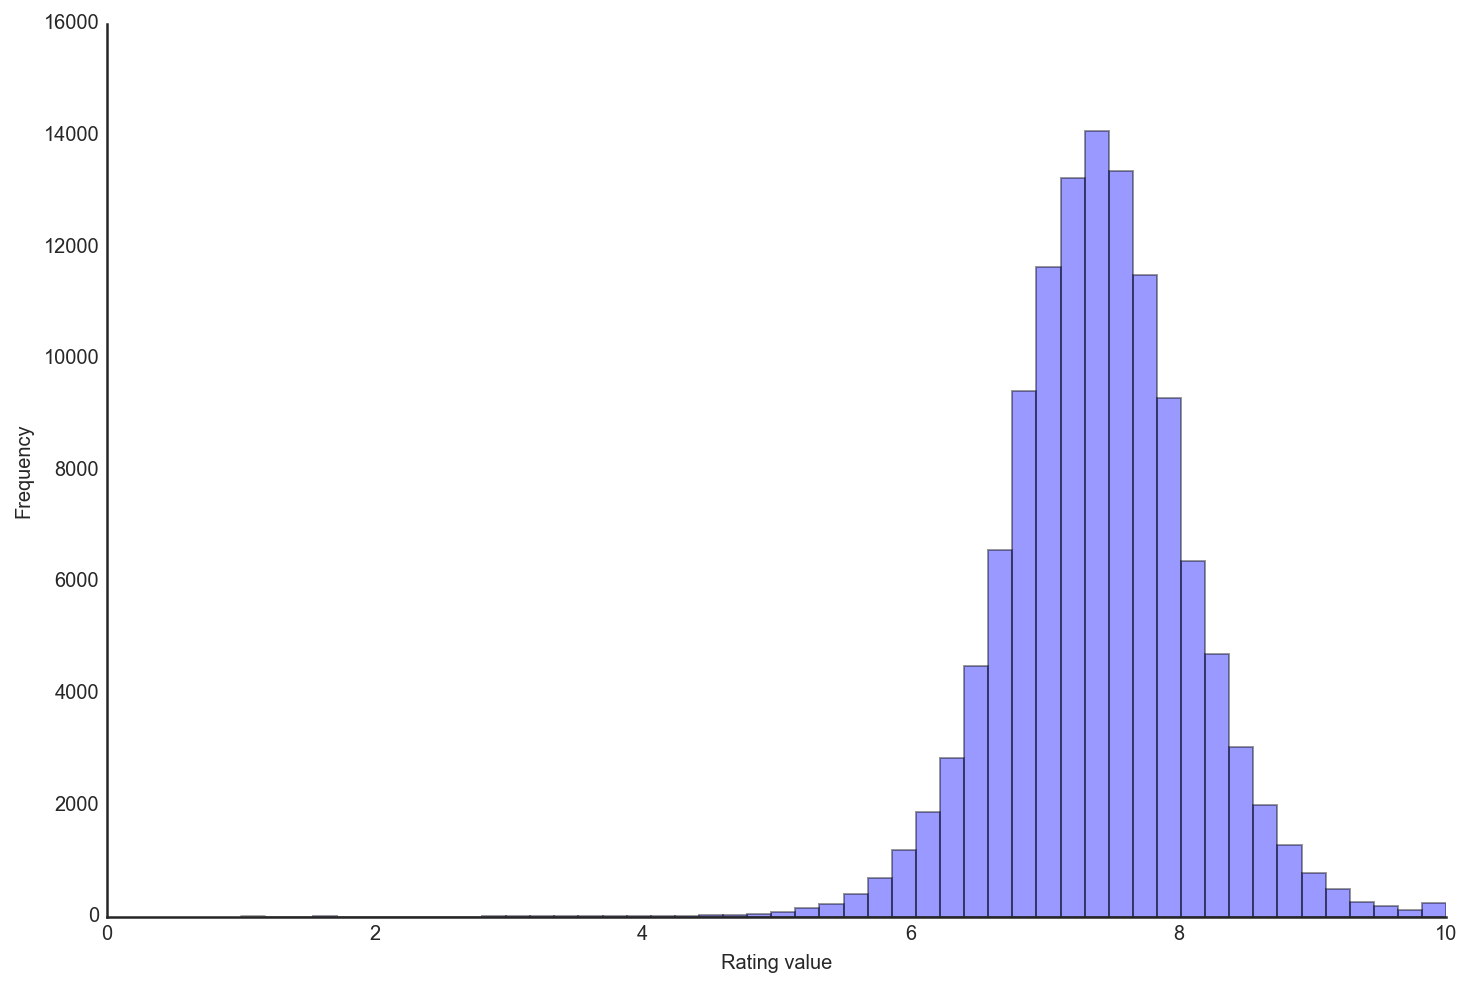

In [38]:
#Plot of average user rating
plt.figure(figsize=(12,8))
sns.distplot(user_ratings_mean, kde=False)
sns.despine()
plt.xlabel('Rating value')
plt.ylabel('Frequency')
plt.show()

>The mean ratings of all our users follow a normal distribution suggesting that most users give an average rating between 7 and 8. The actual mean rating given is about 7.4. There are users that have mean ratings as high as 10 but very few with mean ratings less than 5. We will need to normalize their ratings in order to make comparisons in the next step

In [105]:
ratings_pivot.to_pickle('ratings_pickle')

In [106]:
rate10.to_pickle('rate10_pickle')

# Appendix

>In line with the project's bonus requirements, I will be outlining an update to the specific aims of this project, the methods and models I will be employing and any risks and assumptions I have identified.

### Specific Aims
>I would like to produce a web app where entering a username on Boardgamegeek.com will generate a list of recommendations as my end product.

> I would also like to explore different models for providing recommendations and evaluating them on a list of methods as defined below.

### Methods, Models, Evaluation

> All modeling methods here will be related to collaborative filtering. The alternative would be content-based methods which I will not be exploring in this project


##### Modeling techniques to consider
_Neighborhood models_
- Pearson Correlation
- Cosine Similarity

_Latent Factor models_

- Singular Vector Decomposition
- Weighted Alternating Least Squares (WALS) for matrix factorization
- Matrix Factorization followed by Deep Neural Network

##### Methods
- Surprise module in python
- Tensorflow
- web2py for web app development


### Risks and Assumptions

##### Assumptions related to Recommender systems
- A user's rating of an item, in our case, a game, is determined by a paired set of factors that reflect the characteristics intrinsic to that user and the characteristics intrinsic to that item
- A user's tastes do not change over time
- An item's characteristics do not change over time

##### Assumptions related to this project
- Have enough computing power to process data
- Have enough time to complete all goals set

##### Potential risks and mitigation

Risks | Mitigation
:---: | :---:
Do not have enough computing power to process all the data | Explore Google cloud, AWS; Use less data
Do not have enough time to finish project | Pace properly; Be less ambitious